# MGMGT 638-001 Assignment 1 

Author: Francho Garcia Takis <br>
Date: 06-11-2024

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import statsmodels.formula.api as smf
from pandas_datareader import DataReader as pdr

np.random.seed(6112024)

## Moving Averages Strategy

Choose a stock and backtest a moving average strategy.  Evaluate the strategy relative to buy and hold based on mean return and Sharpe ratio.

### Selecting the Stock

In [2]:
tickers_data = pd.read_csv('../data/stock_data.csv')
all_tickers = list(tickers_data['Symbol'].unique())

In [3]:
def get_stock_data(ticker=None):
    """
    Gets the adjusted closing price data for a random stock (if left unspecified)
    or the adj. closing price of the specified stock for the period that is available.
    """
    if ticker is None:
        ticker = np.random.choice(all_tickers) # get a random stock from the tickers list
        print(f"Getting data for stock {ticker}")

    #Get the Adj Close data for the stock
    data = yf.download(ticker)['Adj Close']
    data.index = pd.to_datetime(data.index.strftime('%Y-%m-%d'))
    data = pd.DataFrame(data)
    data.columns = ['Close'] # rename for ease of use

    return data, ticker

In [4]:
data, name = get_stock_data()

Getting data for stock SYBT


[*********************100%***********************]  1 of 1 completed


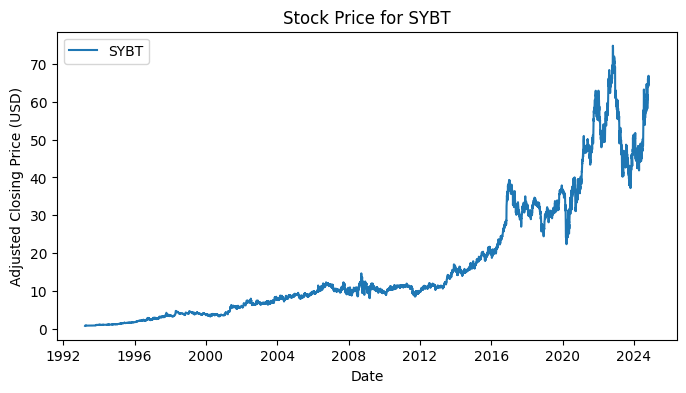

In [5]:
plt.figure(figsize=(8, 4)) 
plt.plot(data, label=name)
plt.title(f'Stock Price for {name}')
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price (USD)')
plt.legend()

plt.show()

### Creating the Moving Averages

In [6]:
#Creating different moving averages to compare: 
data['five_MA'] = data['Close'].rolling(window=5).mean() # 5-day moving average
data['ten_MA'] = data['Close'].rolling(window=10).mean() # 10-day 
data['twenty_MA'] = data['Close'].rolling(window=20).mean() # 20-day

#Creating the 50 day moving average to use as the signal for the strategy
data['fifty_MA'] = data['Close'].rolling(window=50).mean() 

data['five_MA'] = data.five_MA.shift() # Lagging the MA by one day to avoid data leakage
data['ten_MA'] = data.ten_MA.shift()
data['twenty_MA'] = data.twenty_MA.shift()
data['fifty_MA'] = data.fifty_MA.shift()

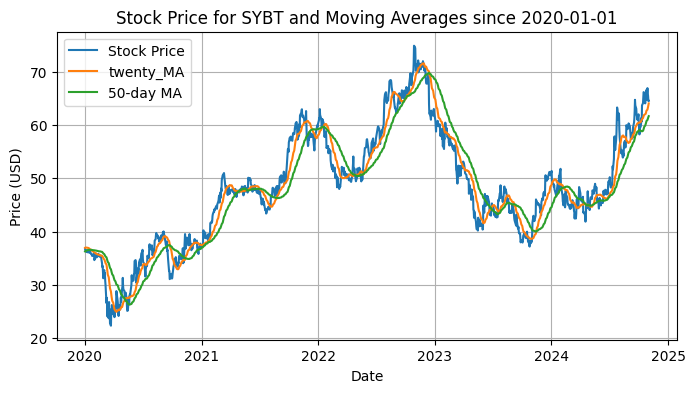

In [7]:
#Graphing the stock price and moving averages 
start_date = pd.Timestamp('2020-01-01') if (
    data.index[0] < pd.Timestamp('2020-01-01') ) else (
         data.index[0]) #Selecting a start date for the graph

selected_MA = 'twenty_MA' # select a specific MA to avoid cluttering the graph with too many

plt.figure(figsize=(8, 4))
plt.plot(data['Close'][start_date:], label='Stock Price')
plt.plot(data[selected_MA][start_date:], label=selected_MA)
plt.plot(data['fifty_MA'][start_date:], label='50-day MA')
plt.title(f'Stock Price for {name} and Moving Averages since {start_date.date()}')
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.grid()

plt.show()

### Computing Returns for the Strategy

In [8]:
# Compute the % change in closing price from previous day: 
data['buy_hold'] = data.Close.pct_change() 

# Calculate whether each day would be buy or not according to each MA strategy:
data['long_five'] = data.five_MA > data.fifty_MA # Buy (True) if 5-day MA > 50-day MA
data['long_ten'] = data.ten_MA > data.fifty_MA 
data['long_twenty'] = data.twenty_MA > data.fifty_MA

# Determine the returns for each day for each strategy:
data['returns_five'] = data.long_five * data.buy_hold 
data['returns_ten'] = data.long_ten * data.buy_hold
data['returns_twenty'] = data.long_twenty * data.buy_hold

data = data.dropna().round(3) # Drop the NA vals and round to 3 decimal places

### Evaluating Moving Strategy Returns & Sharpe Ratio

In [9]:
#Determining the returns from just buying and holding: 
buy_hold = 252*data.buy_hold.mean() 

# Calculating the returns from each MA strategy:
returns_five_MA = 252*data.returns_five.mean()
returns_ten_MA = 252*data.returns_ten.mean()
returns_twenty_MA = 252*data.returns_twenty.mean()

print(f"Returns from buying and holding: {buy_hold:.2%}% annualised")
print(f"Returns from 5-day MA strategy: {returns_five_MA:.2%}% annualised")
print(f"Returns from 10-day MA strategy: {returns_ten_MA:.2%}% annualised")
print(f"Returns from 20-day MA strategy: {returns_twenty_MA:.2%}% annualised")

Returns from buying and holding: 19.70%% annualised
Returns from 5-day MA strategy: 5.42%% annualised
Returns from 10-day MA strategy: 11.18%% annualised
Returns from 20-day MA strategy: 10.66%% annualised


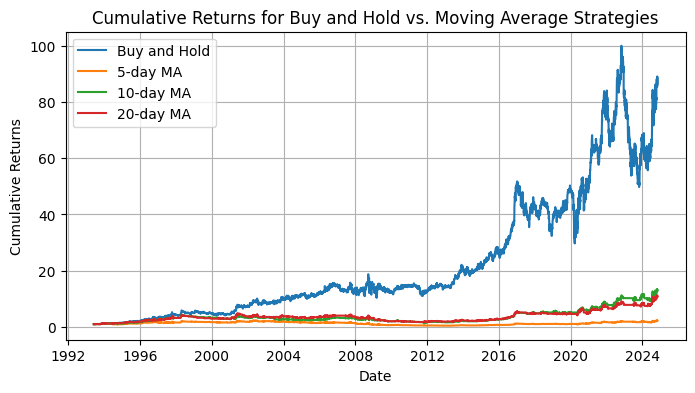

In [10]:
#Plotting the compound returns for each strategy
cumulative_returns_df = pd.DataFrame({
    'Buy and Hold': (1 + data.buy_hold).cumprod(),
    '5-day MA': (1 + data.returns_five).cumprod(),
    '10-day MA': (1 + data.returns_ten).cumprod(),
    '20-day MA': (1 + data.returns_twenty).cumprod()
})

#Select the start date:
start_date = data.index[0]
'''
start_date = pd.Timestamp('2020-01-01') if (
    data.index[0] < pd.Timestamp('2020-01-01') ) else (
         data.index[0]) 
'''

plt.figure(figsize=(8, 4))
plt.plot(cumulative_returns_df[start_date:], label=cumulative_returns_df.columns)
plt.title('Cumulative Returns for Buy and Hold vs. Moving Average Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()

plt.show()

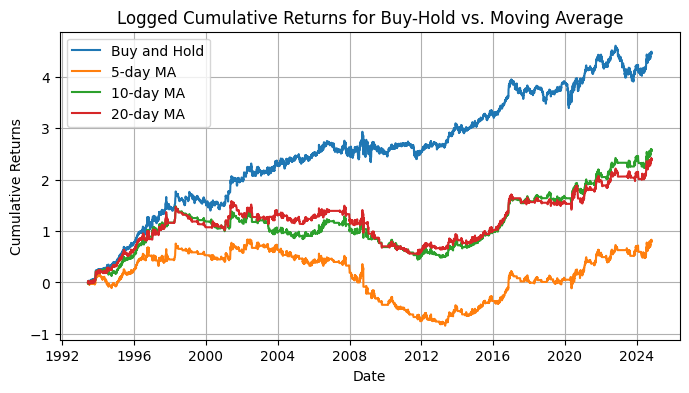

In [11]:
log_cumulative_returns_df = np.log(cumulative_returns_df) # log the returns

plt.figure(figsize=(8, 4))
plt.plot(log_cumulative_returns_df[start_date:], label=log_cumulative_returns_df.columns)
plt.title('Logged Cumulative Returns for Buy-Hold vs. Moving Average')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()

plt.show()

In [12]:
cumulative_returns_df.tail(1)

,Buy and Hold,5-day MA,10-day MA,20-day MA
Date,,,,
2024-11-01,85.847259,2.210246,12.898089,10.781195


In [13]:
# Sharpe Ratios:
rf_rate = 0.0397 
sharpe_buy_hold = (
    (252*data.buy_hold.mean() - rf_rate) / (np.sqrt(252)*data.buy_hold.std())
)
sharpe_five_MA = (
    (252*data.returns_five.mean() - rf_rate) / (np.sqrt(252)*data.returns_five.std())
)
sharpe_ten_MA = (
    (252*data.returns_ten.mean() - rf_rate) / (np.sqrt(252)*data.returns_ten.std())
)
sharpe_twenty_MA = (
    (252*data.returns_twenty.mean() - rf_rate) / (np.sqrt(252)*data.returns_twenty.std())
)

print(f"Sharpe Ratio for Buy and Hold: {sharpe_buy_hold:.2%} annualised")
print(f"Sharpe Ratio for 5-day MA strategy: {sharpe_five_MA:.2%} annualised")
print(f"Sharpe Ratio for 10-day MA strategy: {sharpe_ten_MA:.2%} annualised")
print(f"Sharpe Ratio for 20-day MA strategy: {sharpe_twenty_MA:.2%} annualised")

Sharpe Ratio for Buy and Hold: 47.24% annualised
Sharpe Ratio for 5-day MA strategy: 6.02% annualised
Sharpe Ratio for 10-day MA strategy: 29.22% annualised
Sharpe Ratio for 20-day MA strategy: 26.87% annualised


### Observations
- Usually the buy and hold strategy tends to outperform a moving average strategy of any window size both in terms of annualised returns and sharpe ratio. 
- However, sometimes, like in the case of 'CVE' the moving average strategy can have higher compounded returns when a stock experiences a large sudden drop in price. The buy and hold strategy bears the drop, whilst the moving average strategy exits the position and only re-enters when the trend is reversed.  

## Pairs Strategy

Identify two stocks to use in a pairs strategy.  Backtest the strategy and compute its alpha.

### Identifying a Stock Pair

In [2]:
sector = 'Financials'

sector_tickers = pd.read_csv(f'../data/sector tickers/{sector}.csv')
sector_tickers = sector_tickers['Symbol'].dropna().tolist()

In [3]:
stock_data = pd.DataFrame()

for ticker in sector_tickers:
    try:
        data = yf.download(ticker, progress=False)
        if not data.empty:
            stock_data[ticker] = data['Adj Close'].pct_change() 
    except Exception as e:
        print(f"Error fetching {ticker}: {e}")

corr_matrix = stock_data.corr()
corr_matrix = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

sorted_corrs = corr_matrix.unstack().sort_values(ascending=False).dropna()
sorted_corrs = sorted_corrs.reset_index()
sorted_corrs.columns = ['ticker1', 'ticker2', 'correlation']
sorted_corrs.head()


1 Failed download:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


,ticker1,ticker2,correlation
0,FITB,CFG,0.894116
1,KEY,CFG,0.892703
2,RF,CFG,0.889700
3,HBAN,CFG,0.865308
4,PNC,CFG,0.864888


[*********************100%***********************]  2 of 2 completed


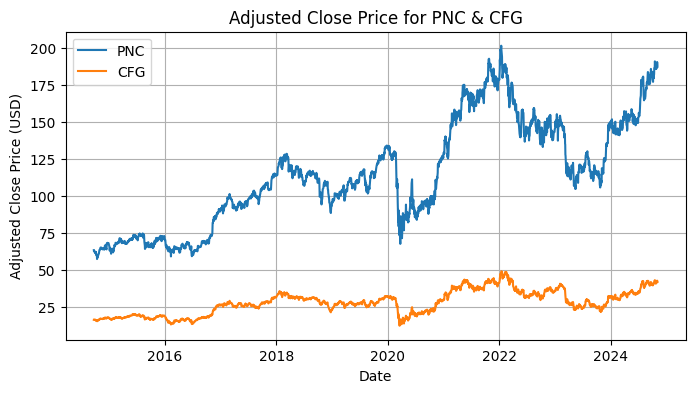

In [71]:
#Select chosen stocks: 
ticker1, ticker2 = 'PNC', 'CFG'

#Get the data:
data = yf.download([ticker1, ticker2])['Adj Close'].dropna() #dropna to keep the data for when both stocks exist
data.index = pd.to_datetime(data.index.strftime("%Y-%m-%d"))

#Plot: 
plt.figure(figsize=(8,4))
plt.plot(data[ticker1], label=ticker1)
plt.plot(data[ticker2], label=ticker2)
plt.title(f"Adjusted Close Price for {ticker1} & {ticker2}")
plt.ylabel('Adjusted Close Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.grid()

plt.show()

### Fitting the Pairs Strategy

In [72]:
#Calculating the ratio between the pair:
data['ratio'] = data[ticker1] / data[ticker2]
data['lagged_ratio'] = data['ratio'].shift()
data['delta_ratio'] = data['ratio'].diff()
data = data.dropna()

In [73]:
# Train and testing splits (80/20):
cutoff_date = data.index[int(0.8*len(data))] 
print(f"Train-test split date: {cutoff_date.date()}")

train = data[:cutoff_date].copy()
print(f"Training set is from {train.index[0].date()} to {train.index[-1].date()}")

test = data[data.index > cutoff_date].copy()
print(f"Testing set is from {test.index[0].date()} to {test.index[-1].date()}")

Train-test split date: 2022-10-25
Training set is from 2014-09-25 to 2022-10-25
Testing set is from 2022-10-26 to 2024-11-01


In [74]:
#Regression formula 
reg = smf.ols(formula='delta_ratio ~ lagged_ratio', data=train)
alpha, beta = reg.fit().params

print("\
Regression Results:")
print(f"Intercept (alpha) {alpha:.2f}")
print(f"Slope (beta): {beta:.2f}")
print(f"Ratio or Constant (-alpha/beta): {-alpha/beta:.2f}")

Regression Results:
Intercept (alpha) 0.05
Slope (beta): -0.01
Ratio or Constant (-alpha/beta): 4.02


### Testing & Evaluating the Pairs Strategy

In [75]:
#Determining a threshold for the buy/short decision on the pair:
threshold = train['ratio'].std() * 2 # Execute if ratio deviated up/down by 2 std devs

#Applying the model to the test data:
test[f'BuyShort_{ticker1}'] = (
    1 * (test.lagged_ratio < -alpha/beta - threshold) # Buy ticker1 if ratio dips below threshold
    - 1 * (test.lagged_ratio > -alpha/beta + threshold) # Short if ratio rises above threshold
)
test[f'BuyShort_{ticker2}'] = -test[f'BuyShort_{ticker1}'] # Inverse for ticker2

#Calculating the returns:
test['returns'] = (
    test[f'BuyShort_{ticker1}'] * test[ticker1].pct_change() 
    + test[f'BuyShort_{ticker2}'] * test[ticker2].pct_change()
)

#Retrieving the market excess returns:
ff = pdr('F-F_Research_Data_Factors_daily', 'famafrench', start=2000)[0]
test['mkt_excess'] = ff['Mkt-RF'] #market excess returns

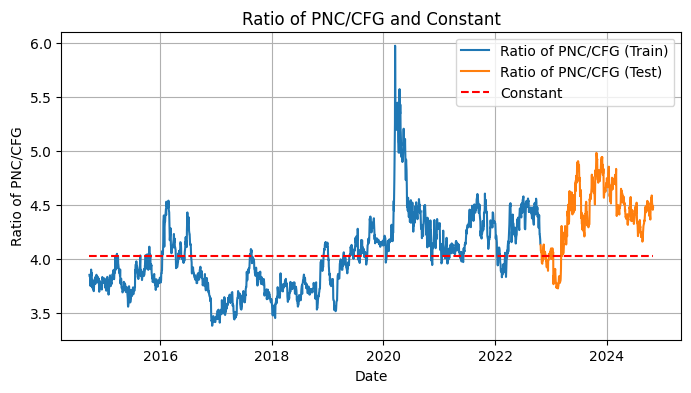

In [76]:
plt.figure(figsize=(8,4))
plt.plot(train['ratio'], label=f"Ratio of {ticker1}/{ticker2} (Train)")
plt.plot(test['ratio'], label=f"Ratio of {ticker1}/{ticker2} (Test)")
#Add the constant (-alpha/beta) to the plot:
plt.hlines(-alpha/beta, 
            xmin=train.index[0], xmax=test.index[-1],
            color='red', linestyle='--', label='Constant')
plt.title(f"Ratio of {ticker1}/{ticker2} and Constant")
plt.ylabel(f"Ratio of {ticker1}/{ticker2}")
plt.xlabel("Date")
plt.legend()
plt.grid()

plt.show()

In [77]:
print(f"Mean return of pairs strategy = {252*test.returns.mean():.2%} annualized")
print(f"Correlation of pairs strategy with market = {test.returns.corr(test.mkt_excess):.2f}")

Mean return of pairs strategy = 12.65% annualized
Correlation of pairs strategy with market = 0.10


In [78]:
test_beta = test.returns.corr(test.mkt_excess) * test.returns.std() / test.mkt_excess.std()
test_alpa = test.returns.mean() - test_beta * test.mkt_excess.mean()

print(f"Beta of pairs strategy = {test_beta:.4f}")
print(f"Annualised alpha is {252*test_alpa:.2%}")

Beta of pairs strategy = 0.0005
Annualised alpha is 11.71%


In [79]:
smf.ols(formula='returns ~ mkt_excess', data=test).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                returns   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     4.679
Date:                Sat, 02 Nov 2024   Prob (F-statistic):             0.0310
Time:                        17:07:06   Log-Likelihood:                 1864.9
No. Observations:                 483   AIC:                            -3726.
Df Residuals:                     481   BIC:                            -3717.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0005      0.000      2.094      0.037    3.01e-05       0.001
mkt_excess     0.0005      0.000      2.163      0.031    4.95e-05       0.001
==============================================================================
Omnibus:                      361.509   Durbin-Watson:                   2.242
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10060.425
Skew:                           2.899   Prob(JB):                         0.00
Kurtosis:                      24.593   Cond. No.                         1.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Observations
- This strategy seems market neutral given the near-zero correlation with the market excess returns. In the case of FITB/CFG the $\beta$ is also near zero and statistically insignificant at the 5% level, whilst in the case of PNC/CFG it is statistically significantly greater than 0, but very small in size. 

- For FITB/CFG the annualised alpha shows that the returns of the strategy seemingly are 3.45% above what would be expected for the level of market risk of the strategy. However, the regression results show these $\alpha$ returns are not statistically significant. For PNC/CFG, annualised alpha seems to be 11.7% according to the 2 years of data, but a regression places it closer to 0.05% although indeed statistically significant. 

- The importance of the threshold and the correlation between the pair: In the case of HBAN/CFG, the ratio of the price of the stocks is remarkably constant and thus produces a case where the threshold is never superceeded to execute a buy/short trade. 